In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../src")
import image_to_numpy 
from scipy import signal

from scipy import ndimage
from sklearn.mixture import GaussianMixture

# Identifying crystalline regions thorugh convolutions

Crystalline regions can be automatically identified starting from example regions. These act as convolution kernels, which can be rotated in order to account for possible variation in orientation.

### Step 1: Identify a crystalline kernel

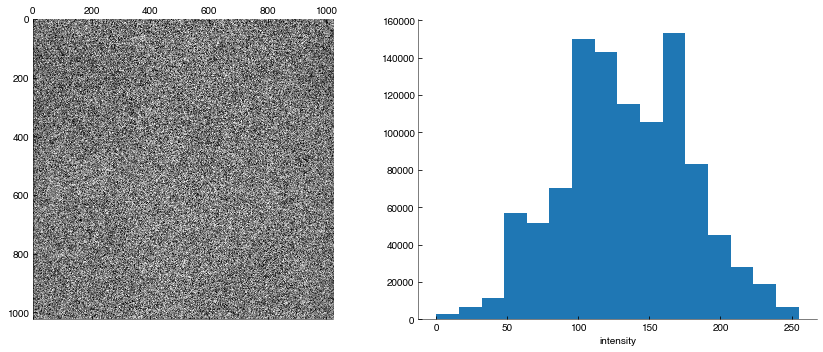

In [63]:
reader = image_to_numpy.Reader("../exp-data/0.524squ.png")

We select a specific square region with corner in (30,70) for ouur crysatlline kernel.

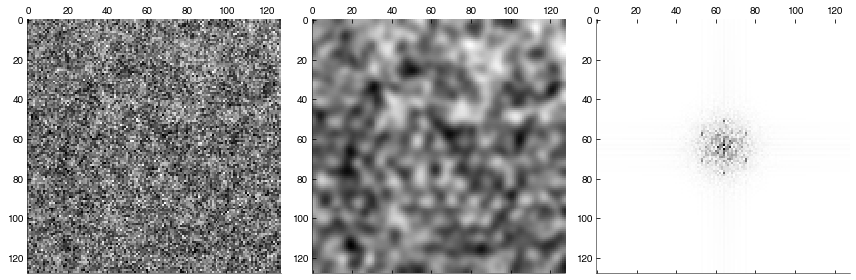

In [194]:
reader.get_kernel(si=30,sj=70, width=128, smoothing=2.0)

First we write down an explicit algorithm that performs the convolutions. We do the following:
- we decide how many rotation we perform
- for every rotation we convolve the kernel $K$ with the image $I$
- we stack the convolution $\tilde{I}\ast \tilde{K}$ into a 3D array
- we then get a 2D image extracting the max along the stacked dimension

Notice that, due to the convolution, a border as thick as hakf the kernel will be created with nonphysical information, and it must be removed (information loss).

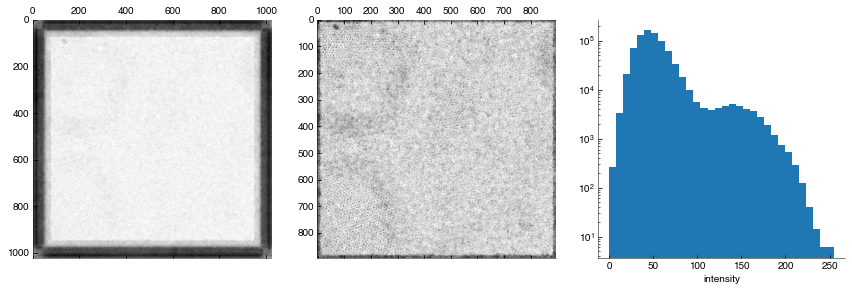

In [195]:
nrotations = 20
nrotations += 1
dtheta = 360/nrotations
convolutions = []

for i in range(nrotations):
    angle = i*dtheta
    k = ndimage.rotate(reader.kernel,angle)
    conv = signal.fftconvolve(reader.image, k, mode='same')
    convolutions.append(conv)

convolutions = np.array(convolutions)
# from every rotation, pick only the largest contribution
poolmax = convolutions.max(axis=0)

fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].matshow(poolmax,cmap=plt.cm.binary);
# remove a border of thinkess kernel/2
b = int(reader.width/2)
poolmax = poolmax[b:-b, b:-b]
poolmax = (poolmax-poolmax.min())/poolmax.ptp()*255
ax[1].matshow(poolmax,cmap=plt.cm.binary);
ax[2].hist(poolmax.ravel(), bins=32); ax[2].set_xlabel('intensity'); ax[2].set_yscale('log')

We now need to threshold the image resulting from the convolution to more clearly decide between crystal and non-crystalline regions. A first option is a binary filter, like the Otsu threshold:

A more refined way is to decompose the intensity spectrum in subpopulations with hgaussian mixtures.

(0.0, 896.0, 0.0, 896.0)

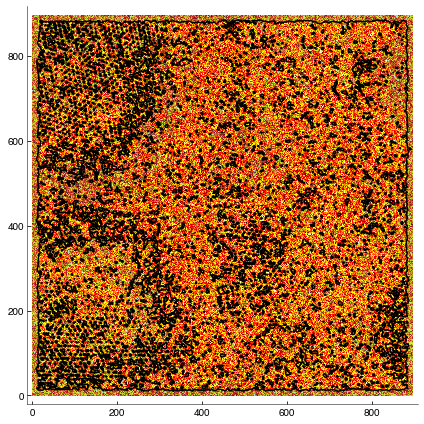

In [196]:

#gaussian mixture model: decompose the intesnity histogram into 3 gaussians: liquid, interface,crystal
X =np.empty(  (len(poolmax.ravel()),1) )
X[:,0] = poolmax.ravel()
gm = GaussianMixture(n_components=4, random_state=0).fit(X)
mean = gm.means_
#  use the model to label the image
u = gm.predict(X)

crystal_label_1 = u[X[:,0].argmax()]
crystal_label_2 = u[u!=crystal_label_1][X[u!=crystal_label_1,0].argmax()]
# crystal_label_3 = u[(u!=crystal_label_1)*(u!=crystal_label_2)][X[(u!=crystal_label_1)*(u!=crystal_label_2),0].argmax()]

labelled = u.reshape(poolmax.shape)
plt.figure(figsize=(6,6))
b = int(reader.width/2)
plt.pcolormesh(reader.image[b:-b,b:-b], cmap = plt.cm.hot)

plt.contourf((labelled==crystal_label_1)+(labelled==crystal_label_2), [.5, 1.5], alpha=0.25, origin='upper')#, alpha=0.03, cmap=plt.cm.binary)
plt.contour((labelled==crystal_label_1)+(labelled==crystal_label_2), [.5], colors="k")

plt.axis('equal')